<div style='text-align: center;'>
    <img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSQzJzIHdangJTrH2mFXFgsLjuLCjpfXXwbxg&usqp=CAU' width='100'/>
    <h1>Sharif University of Technology</h1>
    <h2>Natural Language Processing</h2>
    <h3>Final Project</h3>
    <h4>Spoiler classification and summary generation</h4>
    <p><strong>Authors:</strong> Ali Nikkhah, Ramtin Khoshnevis, Sarina Zahedi</p>
    <p><strong>(Equal Contribution)</strong></p>
</div>
<hr/>


In [1]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

--------------------------------------------------------------------------------------------------------------------------------------


### **1. Load the Dataset**


In [2]:
import pandas as pd
import json
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset
file_path = '/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json'
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)


### **2. Exploratory Data Analysis (EDA)**

In [3]:
from tabulate import tabulate
import numpy as np

# Basic info
info = df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  object
 6   review_summary  573913 non-null  object
dtypes: bool(1), object(6)
memory usage: 26.8+ MB


In [4]:
# Describe the dataset
description = df.describe()


# Check for missing values
missing_values = df.isnull().sum()


# Distribution of spoiler vs. non-spoiler
spoiler_distribution = df['is_spoiler'].value_counts(normalize=True)

# Length of reviews
df['review_length'] = df['review_text'].apply(len)
review_length_description = df['review_length'].describe()



In [5]:
# Display the results

print("\nMissing Values:")
print(tabulate(missing_values.items(), headers=["Column", "Missing Values"], tablefmt="pretty"))

print("\nSpoiler vs. Non-Spoiler Distribution:")
print(tabulate(spoiler_distribution.items(), headers=["Is Spoiler", "Proportion"], tablefmt="pretty"))

print("\nReview Length Description:")
print(tabulate(review_length_description.items(), headers=["Statistic", "Value"], tablefmt="pretty"))


Missing Values:
+----------------+----------------+
|     Column     | Missing Values |
+----------------+----------------+
|  review_date   |       0        |
|    movie_id    |       0        |
|    user_id     |       0        |
|   is_spoiler   |       0        |
|  review_text   |       0        |
|     rating     |       0        |
| review_summary |       0        |
+----------------+----------------+

Spoiler vs. Non-Spoiler Distribution:
+------------+---------------------+
| Is Spoiler |     Proportion      |
+------------+---------------------+
|   False    | 0.7370263437141169  |
|    True    | 0.26297365628588304 |
+------------+---------------------+

Review Length Description:
+-----------+--------------------+
| Statistic |       Value        |
+-----------+--------------------+
|   count   |      573913.0      |
|   mean    | 1460.5535246631457 |
|    std    | 1125.577018615146  |
|    min    |        18.0        |
|    25%    |       719.0        |
|    50%    |     

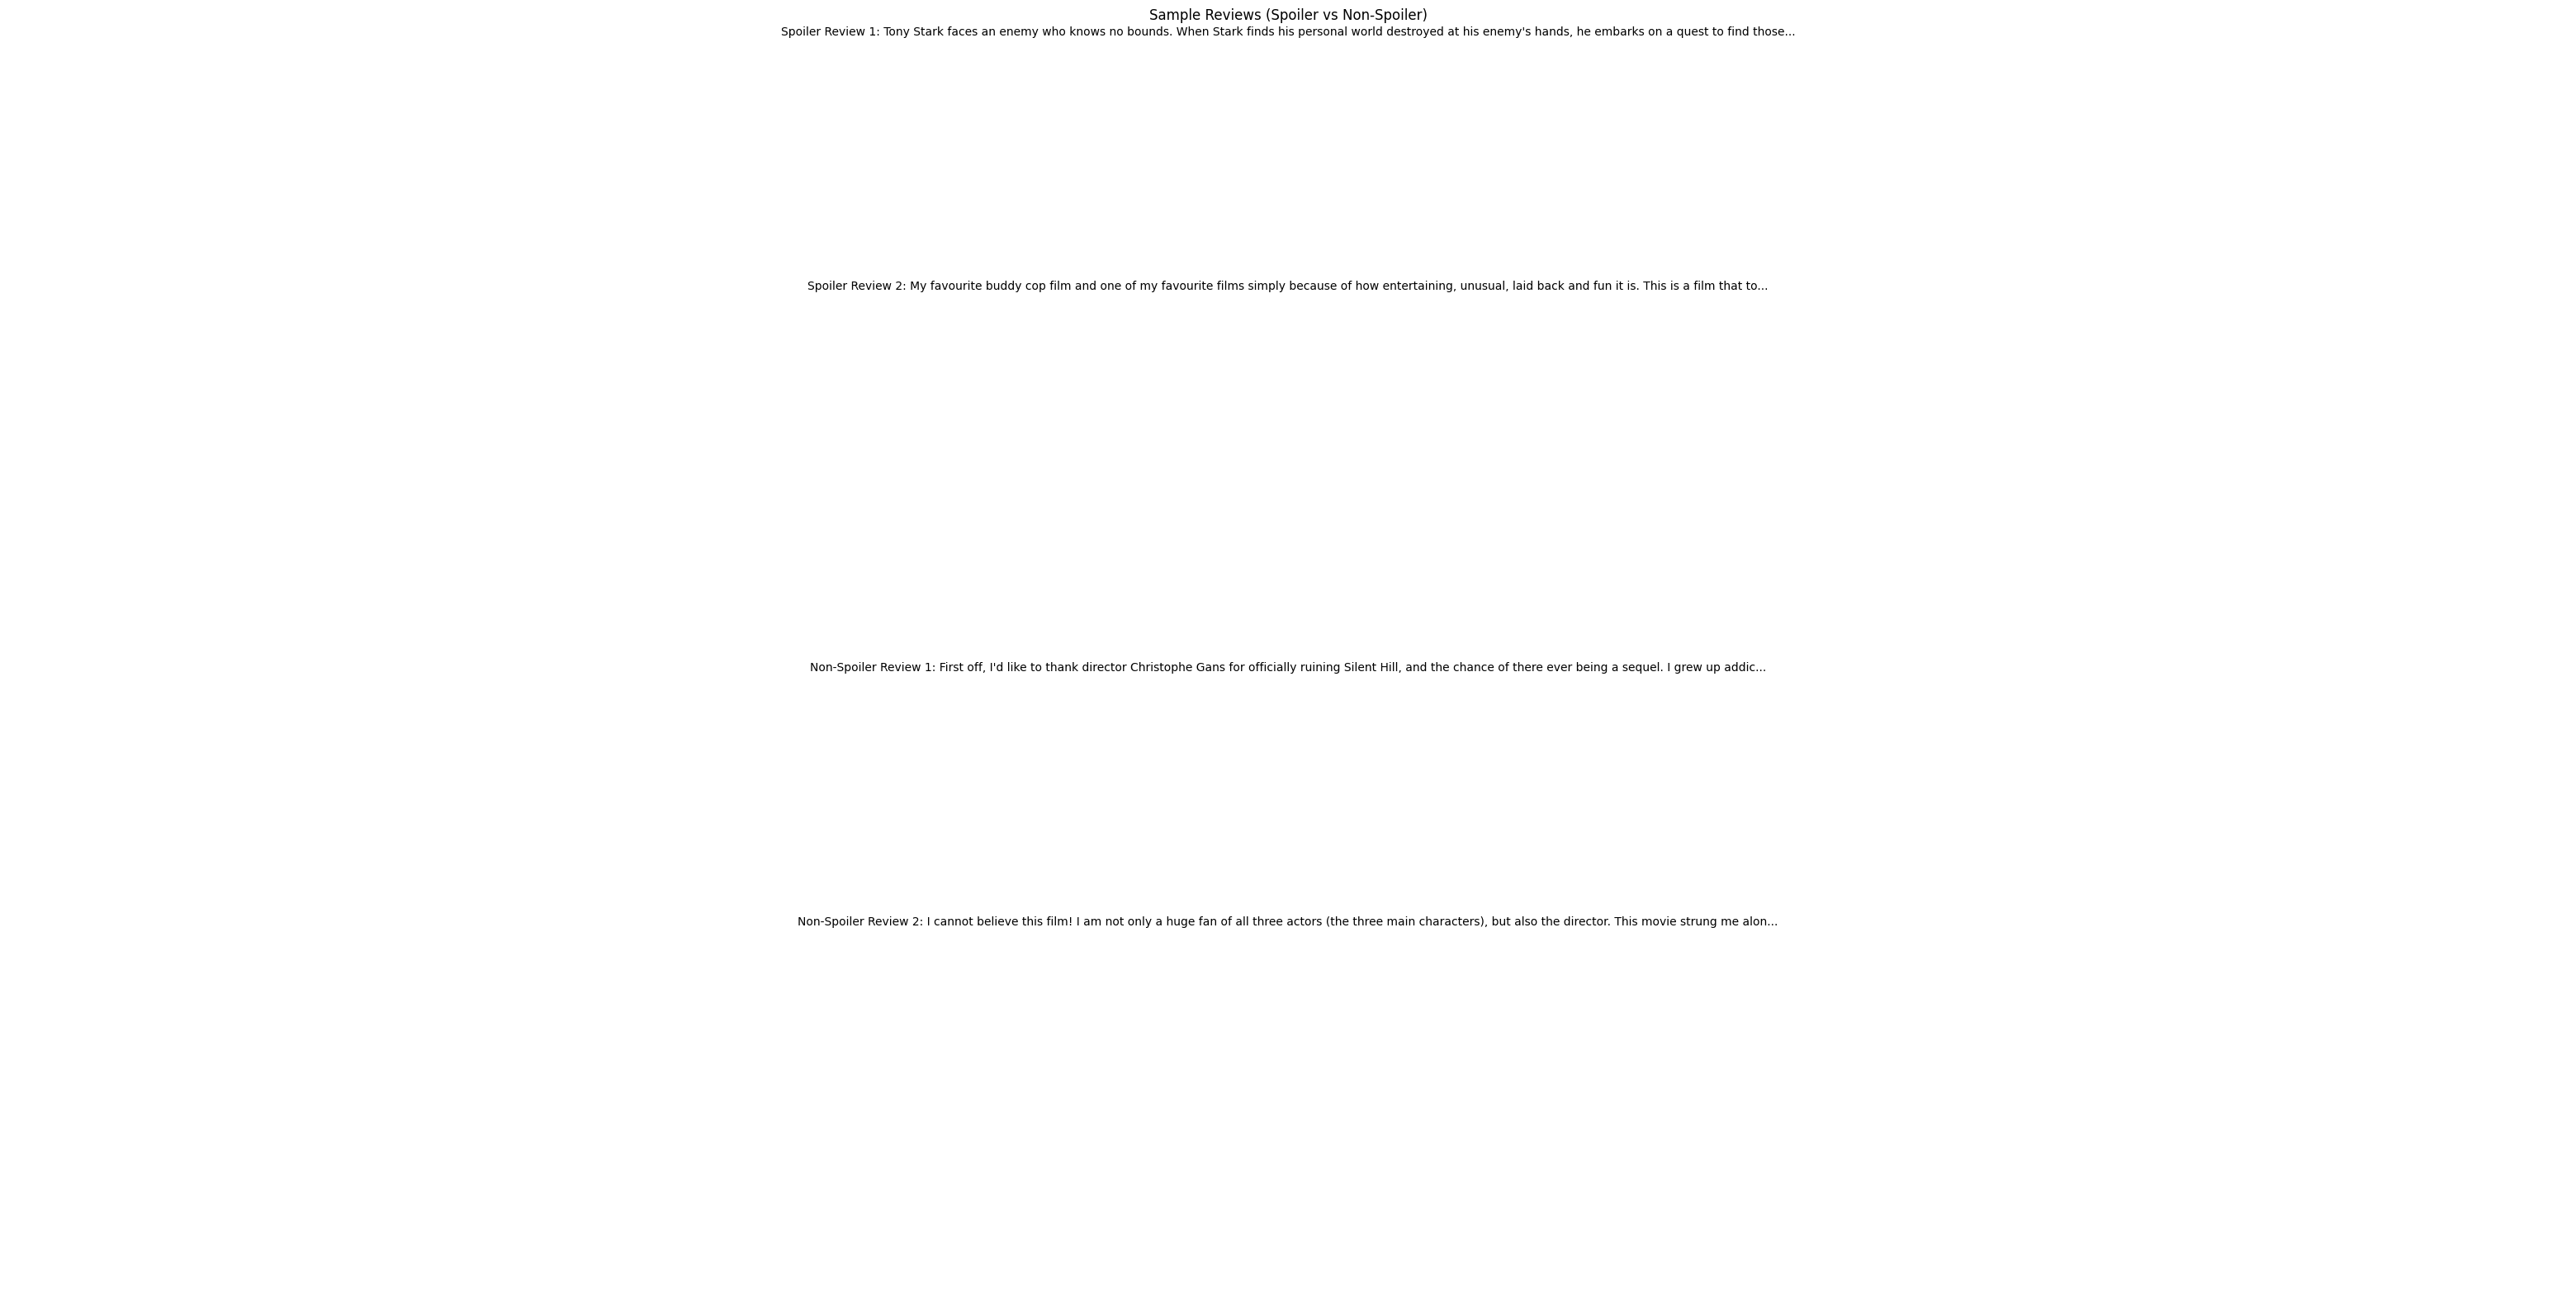

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot some samples of the dataset
sample_size = 2

spoiler_samples = df[df['is_spoiler'] == True].sample(sample_size)
non_spoiler_samples = df[df['is_spoiler'] == False].sample(sample_size)

plt.figure(figsize=(40, 20))

# Spoiler samples
for i, review in enumerate(spoiler_samples['review_text']):
    plt.text(0.5, 1.0 - i*0.2, f"Spoiler Review {i+1}: {review[:150]}...", ha='center', va='top', wrap=True)

# Non-Spoiler samples
for i, review in enumerate(non_spoiler_samples['review_text']):
    plt.text(0.5, 0.5 - i*0.2, f"Non-Spoiler Review {i+1}: {review[:150]}...", ha='center', va='top', wrap=True)

plt.axis('off')
plt.title('Sample Reviews (Spoiler vs Non-Spoiler)')
plt.show()


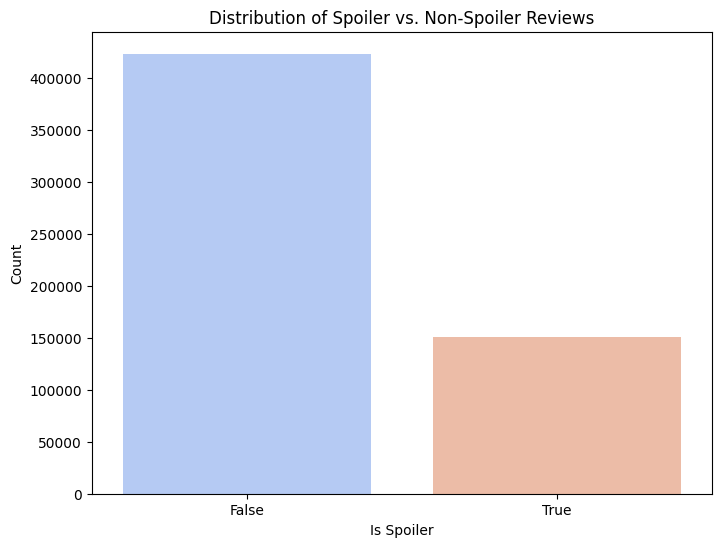

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


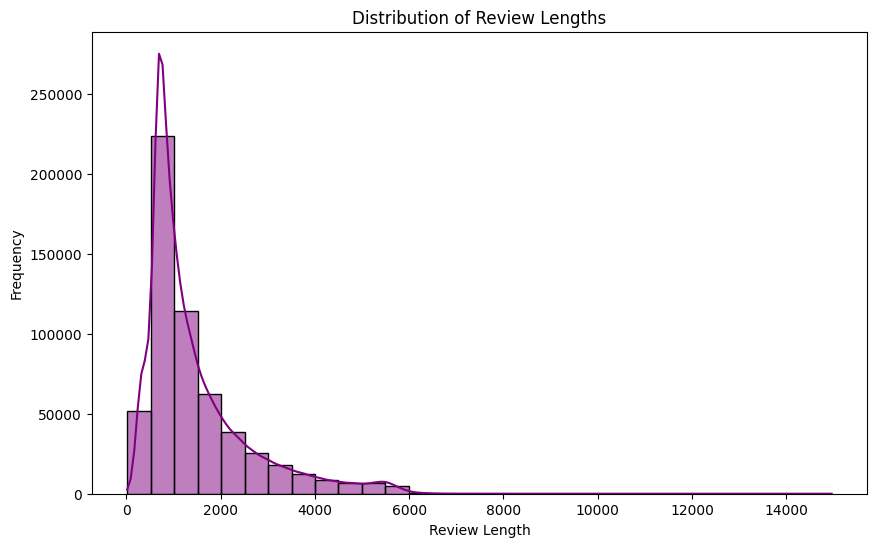

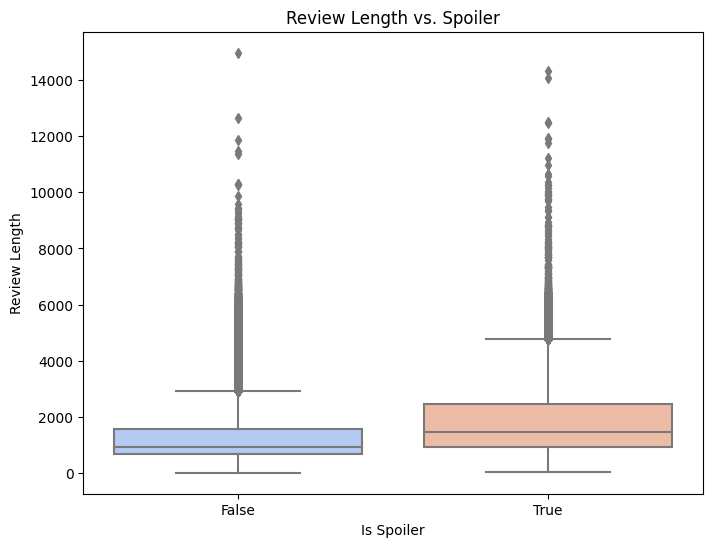

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of spoilers vs. non-spoilers
plt.figure(figsize=(8, 6))
sns.countplot(x='is_spoiler', data=df, palette='coolwarm')
plt.title('Distribution of Spoiler vs. Non-Spoiler Reviews')
plt.xlabel('Is Spoiler')
plt.ylabel('Count')
plt.show()

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], kde=True, bins=30, color='purple')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Correlation between review length and is_spoiler
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_spoiler', y='review_length', data=df, palette='coolwarm')
plt.title('Review Length vs. Spoiler')
plt.xlabel('Is Spoiler')
plt.ylabel('Review Length')
plt.show()


### **2.B. Rule based methods, spoiler contining frequent words and phrases**

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm.notebook import tqdm
# Set of English stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    
    # Remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)
    
    # Remove all non-word characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Normalize whitespaces
    text = re.sub(r'\s+', ' ', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    return text
# Set up tqdm for pandas apply
tqdm.pandas(desc="Cleaning Text")

# Apply the cleaning function with a progress bar
df['cleaned_review_text'] = df['review_text'].progress_apply(clean_text)

Cleaning Text:   0%|          | 0/573913 [00:00<?, ?it/s]

In [18]:
# Specify the path where you want to save the JSON file
json_file_path = '/kaggle/working/preprocessed.json'  

# Save the DataFrame to a JSON file
df.to_json(json_file_path, orient='records', lines=True)

print(f"DataFrame saved successfully to {json_file_path}.")

DataFrame saved successfully to /kaggle/working/preprocessed.json.


### **3. Data Preprocessing**

In [19]:
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer




# Encode the target label
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['is_spoiler'])


train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])




# Re-split the validation and test sets (no need to apply SMOTE here)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])


In [20]:

val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])



In [21]:

class SpoilerDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = tokenizer.encode_plus(
            text,
            max_length=5000,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [22]:

# Create datasets with the resampled training data
train_dataset = SpoilerDataset(train_df['cleaned_review_text'].tolist(), train_df['label'].tolist())
val_dataset = SpoilerDataset(val_df['cleaned_review_text'].tolist(), val_df['label'].tolist())
test_dataset = SpoilerDataset(test_df['cleaned_review_text'].tolist(), test_df['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### **4. Modeling**

### **5. Training and Evaluation**

LSTM model


In [ ]:

# Training function
def train_lstm(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_acc = 0

    # Wrap the dataloader with tqdm for progress tracking
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

    return total_loss / len(dataloader), total_acc / len(dataloader)


In [ ]:
# Evaluation function
def evaluate_lstm(model, dataloader):
    model.eval()
    total_acc = 0

    with torch.no_grad():
        # Wrap the dataloader with tqdm for progress tracking
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)

            total_acc += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

    return total_acc / len(dataloader)


In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_accuracies = []


In [ ]:


n_epochs = 2
# Initialize tqdm progress bar
for epoch in tqdm(range(n_epochs), desc='Training Epochs'):
    train_loss, train_acc = train_lstm(lstm_model, train_loader, optimizer, criterion)
    val_acc = evaluate_lstm(lstm_model, val_loader)
    
    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Print epoch information
    tqdm.write(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}')
    
    # Save model checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f'lstm_model_epoch_{epoch+1}.pth'
        torch.save(lstm_model.state_dict(), checkpoint_path)
        print(f'Model checkpoint saved to {checkpoint_path}')

# Evaluate on test set
test_acc = evaluate(lstm_model, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of LSTM model')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(n_epochs), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of LSTM model')
plt.legend()

plt.tight_layout()
plt.show()


Saving the final model

In [ ]:
# Save the final model completely after training
final_model_path = 'final_lstm_model.pth'
torch.save(lstm_model, final_model_path)
print(f'Final model saved to {final_model_path}')